MCB 112 - Problem Set Week 6

In [3]:
# import packages
import numpy as np
import matplotlib.pyplot as plt     
import scipy.stats as stats
import scipy.special as special
import seaborn as sns
import watermark

# The beginner's game

First, let's try running the provided script to see the output we get:

Welcome to Student's game night...

The RNG seed is 831112

The hidden grid has 20 rows for sigma 100.0..5.0,
                and 21 cols for mu -100.0..100.0.

Student picked grid col = 18, row = 2
and thus mu = 80.0, sigma = 90.0

Student's tea distribution machine shows the customers 3 samples:
    232.17
      1.88
    150.15

which give sample mean:   128.07
   and sample std.dev.:   116.72


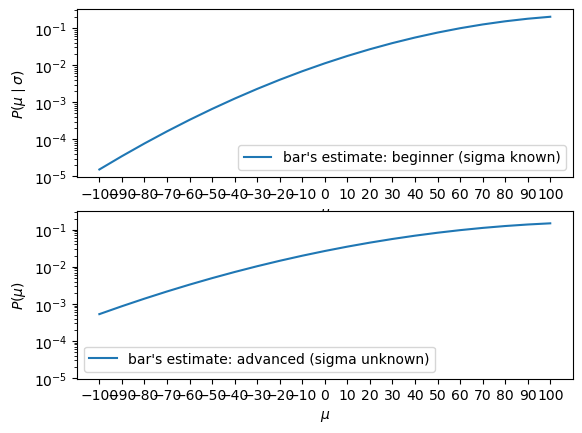

In [4]:
%run student-game.py 3

Now, let's try working on the beginner's game.  Fortunately, since we are given the true $\sigma$ based on the row that Student tells us, we just need to estiamte $\mu$ based on our observed data $x_1, x_2, ..., x_n$ and known $\sigma$.  We are also told that the way Student's machine drops tea bags (let's call this $B$) is distributed normally, i.e. $B \sim \mathcal N (\mu, \sigma)$, and that the prior is uniform.  That means that to calculate the posterior probability $P(\mu | x_1, x_2, ..., x_n, \sigma)$ for each of the possible $\mu$ values provided us, we can utilize the fact that with a uniform prior, the posterior is proportional to the likelihood.  We just have to normalize at the end to make sure our probabilities sum to 1, which is aided by the fact that we have a discrete set of possible $\mu$ and $\sigma$ values.

In [38]:
# set our global vars for this example
mu_values = np.arange(-100, 110, 10)
sigma_values = np.arange(5,105,5)
x = np.array([11.50, -2.32, 9.18])
true_sigma = 60.0

def find_beg_posterior(X, true_sigma, mu_values):

    # calculate likelihoods based on the normal distribution
    likelihoods = np.array([np.prod(stats.norm.pdf(X, loc=mu, scale=true_sigma)) for mu in mu_values])

    # calculate the posterior. Since the prior P(mu) is uniform, we consider the posterior proportional to likelihoods
    posterior = likelihoods / np.sum(likelihoods)  # normalize

    return posterior

# this code is taken from the hint in the problem set
def probdist_beginner(X, sigma, mu_values):
    """ 
    Given an ndarray X_1..X_n, and a known sigma;
    and a list of the mu values in each column;
    return a list of the pub's inferred P(mu | X,sigma) for each column.
    """
    xbar = np.mean(X)
    N    = len(X)
    Pr   = [ stats.norm.pdf(x, loc=xbar, scale= sigma / np.sqrt(N)) for x in mu_values ]  # proportional to std error of the mean
    Z    = sum(Pr)                   # normalization constant
    Pr   = [ p / Z for p in Pr ]     # normalization to a discrete probability distribution
    return Pr

Now that we have a function that calculates our posterior distribution for the beginner's game, together with the "hint" code provided in the problem set, we can try running these with the sample data and plotting them:

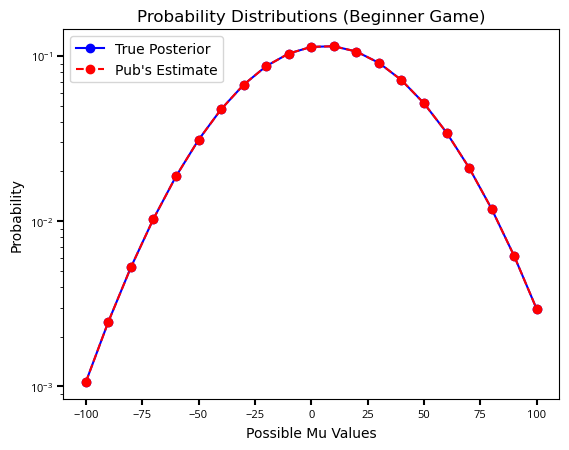

In [39]:
# run calculations
posterior = find_beg_posterior(x, true_sigma, mu_values)
pub_dist = probdist_beginner(x, true_sigma, mu_values)

# plot!
fig, ax = plt.subplots()

ax.semilogy(mu_values, posterior, 'b-o', label='True Posterior')
ax.semilogy(mu_values, pub_dist, 'r--o', label='Pub\'s Estimate')
ax.set_title('Probability Distributions (Beginner Game)')   
ax.set_xlabel('Possible Mu Values', size=10)
ax.set_ylabel('Probability', size=10)
ax.tick_params(axis='both', which='major', direction='out', length=4, width=1.5, labelsize=8, labelfontfamily='Open Sans')
ax.legend() 


We see here that for the beginner's game, the pub's distribution does a good job estimating the distribution.  Even with the log-scale graph, there seems to be no easily discernible difference between the two.

# The advanced game

Now, let's try writing the same code, but for the advanced game.  We must start with the joint posterior, then we can marginalize later by summing.  Again, using the fact that our prior is uniformly distributed, the joint posterior will be proportional to the likelihood.  This means that for each combination of $\mu$ and $\sigma$, we can compute the likelihood and by extension, also the posterior probability.  Normalizing at the end will allow us to ensure that the probabilities sum to 1.

In [7]:
def find_adv_posterior(X, sigma_values, mu_values):
    
    # initialize
    posterior = np.zeros((len(sigma_values), len(mu_values)))

    for i, sigma in enumerate(sigma_values):

        likelihood_mu = np.array([np.prod(stats.norm.pdf(X, loc=mu, scale=sigma)) for mu in mu_values])
        # save for each set
        posterior[i, :] = likelihood_mu

    # normalize the posterior
    posterior /= np.sum(posterior)
    
    return posterior


# code taken from hint on problem set
def probdist_advanced(X, mu_values):
    """ 
    Given an ndarray X_1..X_n,
    and a list of the mu values in each column;
    return a list of the pub's inferred P(mu | X) for each column.
    """
    xbar = np.mean(X)
    s    = np.std(X, ddof=1)     # note that numpy.std() by default calculates a population std dev; to get sample std. dev., set ddof=1
    N    = len(X)
    Pr   = [ stats.norm.pdf(x, loc=xbar, scale= s / np.sqrt(N)) for x in mu_values ]  # proportional to std error of the mean
    Z    = sum(Pr)                   # normalization constant
    Pr   = [ p / Z for p in Pr ]     # normalization to a discrete probability distribution
    return Pr

Now, we have code for the advanced game.  Let's run it, determine the marginalized posterior $P ( \mu | x_1, x_2, ..., x_n)$ by summing over $\sigma$, and plot the joint posterior along with the pub's distribution.

The code to plot the heatmap was taken from the script provided in the problem set.

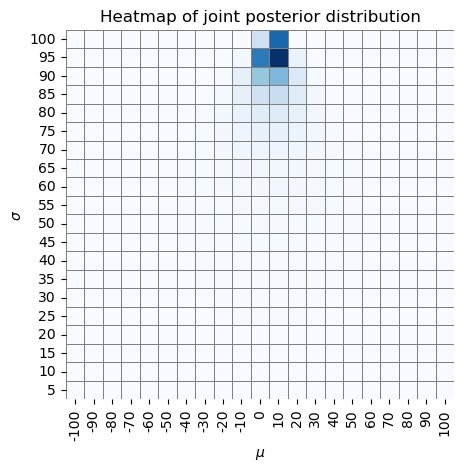

In [8]:
joint_posterior = find_adv_posterior(x, sigma_values, mu_values)
marginal_mu = np.sum(joint_posterior, axis=0)
pub_dist = probdist_advanced(x, mu_values)

### code taken from script in problem set to make heatmap ###

# Set up the x and y coords
gridrows = np.linspace( 100.0,   5.0, 20)   # rows of the board: std. dev., sigma
gridcols = np.linspace(-100.,  100.0, 21)   # cols of the board: mean (location), mu
nrows    = len(gridrows)
ncols    = len(gridcols)
        
# Format axis labels as strings, with values as "10" not "10.0" for clarity, space
xlabels = [ "{0:.0f}".format(val) for val in gridcols ]
ylabels = [ "{0:.0f}".format(val) for val in gridrows ]

data = np.zeros((nrows,ncols))
data[5,5] = 1
# the Seaborn "heatmap" plot
# with some examples of how it can be customized.
#
fig, ax = plt.subplots()
sns.heatmap(joint_posterior,                 # takes a 2D array of data
            ax=ax,
            xticklabels=xlabels,  #   ... set custom x axis labels
            yticklabels=ylabels,  #   ... set custom y axis labels
            cbar=False,           #   ... turn off the default color scale bar
            square=True,          #   ... force the plot to be square
            linecolor='grey',     #   ... set grid line color
            linewidth=0.5,        #   ... set grid line width
            cmap='Blues')         #   ... set the heat map color scheme ('color map', cmap) 

ax.set_title('Heatmap of joint posterior distribution')
ax.set(xlabel=r'$\mu$',                # ...set X axis label, using LaTeX formatting
       ylabel=r'$\sigma$')             # ...and Y axis label
for label in ax.get_yticklabels():    
    label.set_size(10)                 # ... and font size on y-axis tick labels
for label in ax.get_xticklabels():    
    label.set_size(10)                 # ... and on x-axis tick labels

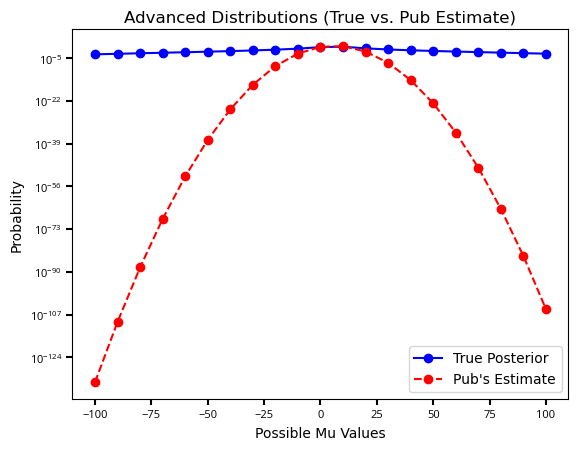

In [9]:
# plot dists

fig, ax = plt.subplots()

ax.semilogy(mu_values, marginal_mu, 'b-o', label='True Posterior')
ax.semilogy(mu_values, pub_dist, 'r--o', label='Pub\'s Estimate')
ax.set_title('Advanced Distributions (True vs. Pub Estimate)')   
ax.set_xlabel('Possible Mu Values', size=10)    
ax.set_ylabel('Probability', size=10)
ax.tick_params(axis='both', which='major', direction='out', length=4, width=1.5, labelsize=8, labelfontfamily='Open Sans')
ax.legend() 

We can see from the heatmap that the heatmap of the joint posterior distribution seems to be suggesting $\sigma$ that is larger than the true value.  This suggests that the pub's estimate of $\sigma$ (using the MLE) may be flawed (an explanation for this is provided in question 3).  Similarly, we see a systematic error in the marginalized $\mu$ distribution, where the true posterior seems to be diverging from the pub's estimate.

# Where's the advantage?

We see that the pub is not calculating its odds correctly--it seems to be systematically underestimating $\sigma$.  To explain this, we can think about how the pub is calculating their estimate, and how that might be incorrect.

We are told in the problem set that the sample standard deviation used by the pub is:

$$ s = \sqrt{ \frac{ \sum_{i=1}^n (\bar x - x_i )^2}{ n - 1 } }$$

We see that this sample standard deviation is directly derived from the Bessel-corrected sample variance:

$$ S^2 = \frac{ \sum_{i=1}^n (\bar x - x_i )^2}{ n - 1 } $$

We know that from the Bessel correction, this sample variance $S^2$ is an unbiased estimator for the population variance.  However, by Jensen's inequality, for a concave function $g(x)$, we know that:

$$\text E [ g(x)] \le g( \text E [x])$$ 

This means that for the sample standard deviation and sample variance above, for the concave square root function: 

$$\text [ \sqrt {S^2}] \le \sqrt { \text E [S^2]}$$

We know that asymptotically, as $n \to \infty$, the Bessel-corrected sample variance is an unbiased estimator of the population variance.  However, we see from Jensen's inequality that by applying a nonlinear function (the concave square root function), we would expect that the expectation of the sample standard deviation, i.e. $\text E [\sqrt { S^2}]$, would be less than the square root of the expectation of the sample variance, $\sqrt { \text E [S^2]}$.  

I will remark on the fun naming in this problem set--having the machine being a *student's tea distribution machine* was certainly a little cheeky, because by estimating $\mu$ for normally distributed data with unknown variance, this is essentially what we're getting--and we see the characteristic curve of the Student-t distribution that has a smaller central peak and fatter tails than the normal distribution when we plot the advanced game in problem 2.  This also supports the above conclusion using Jensen's inequality, since asymptotically with larger $n$, we expect the Student-t distribution to approach the normal distribution. 

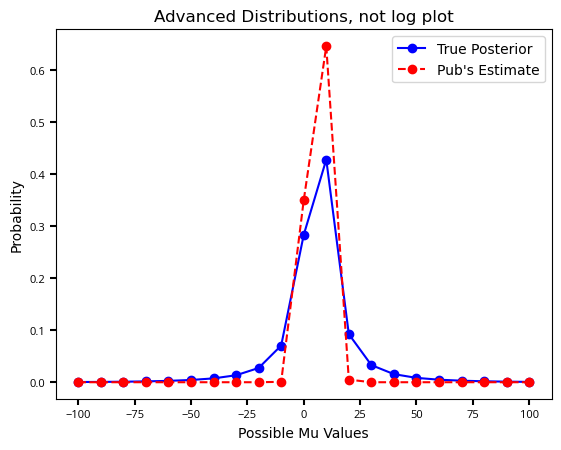

In [10]:
fig, ax = plt.subplots()

ax.plot(mu_values, marginal_mu, 'b-o', label='True Posterior')
ax.plot(mu_values, pub_dist, 'r--o', label='Pub\'s Estimate')
ax.set_title('Advanced Distributions, not log plot')   
ax.set_xlabel('Possible Mu Values', size=10)    
ax.set_ylabel('Probability', size=10)
ax.tick_params(axis='both', which='major', direction='out', length=4, width=1.5, labelsize=8, labelfontfamily='Open Sans')
ax.legend() 

# Bonus

Let's try using the Student-t distribution for the pub and seeing how this would compare to the distributions we have now, and the distribution that the pub is currently using.

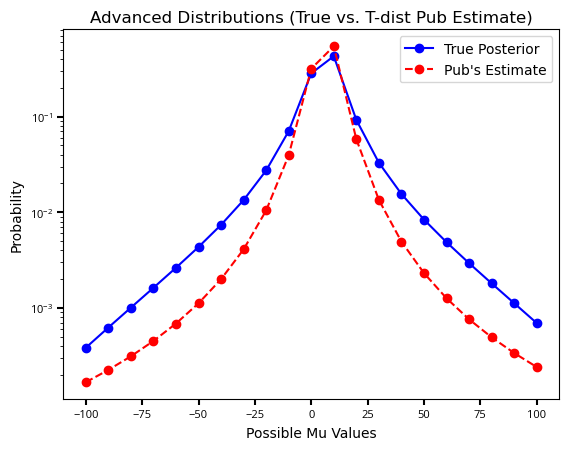

In [18]:
def probdist_t(X, mu_values):
    """ 
    Given an ndarray X_1..X_n,
    and a list of the mu values in each column;
    return a list of the inferred P(mu | X) for each column,
    according to Student's t distribution with N-1 degrees of freedom.
    """
    N    = len(X)
    xbar = np.mean(X)
    s    = np.std(X, ddof=1)
    t    = [ (xbar - mu) / (s / np.sqrt(N)) for mu in mu_values ]    # t statistic, given sample mean, sample stddev, and N
#   t    = [ stats.ttest_1samp(X, mu)[0] for mu in mu_values ]       # ... (equivalently, python can calculate t statistic for you)
    Pr   = [ stats.t.pdf(val, N-1) for val in t ]
    Z    = sum(Pr)
    Pr   = [ p / Z for p in Pr ]    
    return Pr

t_pubdist = probdist_t(x, mu_values)

# plot dists
fig, ax = plt.subplots()

ax.semilogy(mu_values, marginal_mu, 'b-o', label='True Posterior')
ax.semilogy(mu_values, t_pubdist, 'r--o', label='Pub\'s Estimate')
ax.set_title('Advanced Distributions (True vs. T-dist Pub Estimate)')   
ax.set_xlabel('Possible Mu Values', size=10)    
ax.set_ylabel('Probability', size=10)
ax.tick_params(axis='both', which='major', direction='out', length=4, width=1.5, labelsize=8, labelfontfamily='Open Sans')
ax.legend() 

We see here that it is still not perfect (having a larger sample would likely help), but the new pub's estimate using the Student-t distribution is much closer to what we actually see.  The systematic error of underestimating the "tails" of possible $\mu$ values is corrected, although we are still slightly underestimating.

In [9]:
%load_ext watermark 
%watermark -v -m -p numpy,matplotlib,seaborn,pandas,jupyterlab

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.27.0

numpy     : 1.26.4
matplotlib: 3.9.2
seaborn   : 0.13.2
pandas    : 2.2.2
jupyterlab: 4.2.5

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 23.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 12
Architecture: 64bit

